### Imports

In [23]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Macros

In [24]:
datapath = "processed_deck_data.csv"
hidden_layers = (40, 30, 20) # hidden layers
input_size = 0
num_epochs = 502 # number of epochs to train

# Get Data
### already preprocessed, must be all numeric

In [25]:
df = pd.read_csv(datapath)

# last column is the label
X = df.iloc[:, :-1].values  # features

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # fit and transform the features

Y = df.iloc[:, -1].values   # labels

X_train_np, X_test_np, Y_train_np, Y_test_np = train_test_split(X, Y)

# Convert to torch tensors
X_train = torch.tensor(X_train_np).float() # dtype=torch.float32
Y_train = torch.tensor(Y_train_np).float()
X_test = torch.tensor(X_test_np).float()
Y_test = torch.tensor(Y_test_np).float()

# determine size of input space
input_size = X_train.shape[1]

In [26]:
np.average(Y)

np.float64(0.4938918593659632)

# Build Neural Network

In [27]:
layers = list()

if len(hidden_layers) == 0:
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
else:
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.Sigmoid())

    for i in range(1, len(hidden_layers)):
        layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        layers.append(nn.Sigmoid())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    layers.append(nn.Sigmoid())

model = nn.Sequential(*layers)

# prepare for training
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define Train Loop

In [ ]:
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    Y_pred = model(X_train).flatten()
    loss = loss_fn(Y_pred, Y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        with torch.inference_mode():
            # Test the model
            Y_test_pred = model(X_test).flatten()
            test_loss = loss_fn(Y_test_pred, Y_test)

            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2f}')
            print("Y_pred:", Y_pred)

Epoch [1/502], Loss: 0.70
Y_pred: tensor([0.4505, 0.4504, 0.4504,  ..., 0.4504, 0.4504, 0.4504],
       grad_fn=<ViewBackward0>)
Epoch [101/502], Loss: 0.69
Y_pred: tensor([0.4891, 0.4888, 0.4887,  ..., 0.4891, 0.4892, 0.4893],
       grad_fn=<ViewBackward0>)


In [19]:
print("Y_pred:")
print(model(X_test).flatten())
print("Y_test:")
print(Y_test)


Y_pred:
tensor([0.4945, 0.4921, 0.4928,  ..., 0.4942, 0.4945, 0.4939],
       grad_fn=<ViewBackward0>)
Y_test:
tensor([1., 1., 0.,  ..., 1., 1., 0.])


# Save Model & Data

In [22]:
import os
os.listdir(os.getcwd())

['BattlesStaging_01012021_WL_tagged_new.csv',
 'clash_royale_mapped_cards.py',
 'clash_royale_mapped_cards_new.py',
 'data_modified1.csv',
 'model_run_20250702_124556',
 'neural_sketwork.ipynb',
 'processed_deck_data.csv']

In [20]:
import os
from datetime import datetime
import json
import shutil

def save_model_run(model, datapath, hidden_layers, input_size, num_epochs,
                  train_loss_values, test_loss_values, epoch_count):
    # Create a timestamped folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"model_run_{timestamp}"
    os.makedirs(folder_name, exist_ok=True)

    # Save model weights
    model_path = os.path.join(folder_name, "model_weights.pth")
    torch.save(model.state_dict(), model_path)

    # Save configuration details
    config = {
        "datapath": datapath,
        "hidden_layers": hidden_layers,
        "input_size": input_size,
        "num_epochs": num_epochs,
        "timestamp": timestamp,
        "learning_rate": optimizer.param_groups[0]['lr']
    }

    with open(os.path.join(folder_name, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)

    # Save loss values
    loss_data = {
        "epochs": epoch_count,
        "train_loss": train_loss_values,
        "test_loss": test_loss_values
    }
    np.savez(os.path.join(folder_name, "loss_data.npz"), **loss_data)

    # Save plots
    # Loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_count, train_loss_values, label="Train loss")
    plt.plot(epoch_count, test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.savefig(os.path.join(folder_name, "loss_curves.png"))
    plt.close()

    # Calculate and save confusion matrix
    model.eval()
    with torch.no_grad():
        Y_test_pred = model(X_test).flatten()
        predicted_classes = (Y_test_pred >= 0.5).float()
        cm = confusion_matrix(Y_test.numpy(), predicted_classes.numpy())
        accuracy = accuracy_score(Y_test.numpy(), predicted_classes.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Win'],
                yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.4f})')
    plt.savefig(os.path.join(folder_name, "confusion_matrix.png"))
    plt.close()

    # Calculate and save feature importance
    importance = compute_feature_importance_simple(model, X_test_np)
    feature_names = df.columns[:-1]

    plt.figure(figsize=(12, 8))
    importance_sorted_idx = np.argsort(importance)
    plt.barh(range(len(importance)), importance[importance_sorted_idx])
    plt.yticks(range(len(importance)), [feature_names[i] for i in importance_sorted_idx])
    plt.title('Feature Importance')
    plt.xlabel('Mean Absolute Difference in Predictions')
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, "feature_importance.png"))
    plt.close()

    # Copy notebook to the folder if it exists
    try:
        shutil.copy("neural_sketwork.ipynb", os.path.join(folder_name, "neural_sketwork.ipynb"))
    except:
        pass

    print(f"Model and related information saved to folder: {folder_name}")
    return folder_name

# Call the function after training
save_folder = save_model_run(model, datapath, hidden_layers, input_size, num_epochs,
                           train_loss_values, test_loss_values, epoch_count)

Model and related information saved to folder: model_run_20250702_124556


# Make Predictions

In [8]:
model.eval()
with torch.inference_mode():

    # Find our model's learned parameters
    from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
    print("The model learned the following values for weights and bias:")
    pprint(model.state_dict())
    print("\nAnd the original values for weights and bias are:")
    pprint(f"weights: {layers[-2]}")

The model learned the following values for weights and bias:
OrderedDict([('0.weight',
              tensor([[-0.0162,  0.0815, -0.1615,  0.0341,  0.0932, -0.0229,  0.0480,  0.0972,
         -0.1446, -0.0575, -0.0841,  0.0346, -0.2351,  0.2559, -0.1422, -0.0012],
        [ 0.1403, -0.0585,  0.2733, -0.1654, -0.2018, -0.2413,  0.1372,  0.1370,
          0.1616,  0.2125, -0.1812, -0.0298, -0.0115, -0.0619,  0.0292,  0.1992],
        [-0.0272, -0.0486,  0.1491, -0.0857, -0.1276,  0.1791,  0.0219,  0.1756,
         -0.1362, -0.2796, -0.1851, -0.1412,  0.1970, -0.0056,  0.2991,  0.0487],
        [-0.2362, -0.0089,  0.0946, -0.2415,  0.2949,  0.2913,  0.0863,  0.1165,
         -0.1277,  0.0964, -0.2130,  0.1587, -0.1578, -0.0888,  0.1734,  0.1937],
        [-0.0038, -0.0489,  0.2070,  0.1649, -0.2225, -0.1410,  0.0380, -0.0107,
         -0.1167,  0.1376, -0.2204,  0.0436, -0.0129,  0.1275, -0.0634, -0.0224],
        [-0.0319, -0.0734,  0.0423, -0.1152, -0.0750, -0.2110, -0.0521,  0.1970,
   

# Plot Predictions

Large preprocessed dataset, scaled


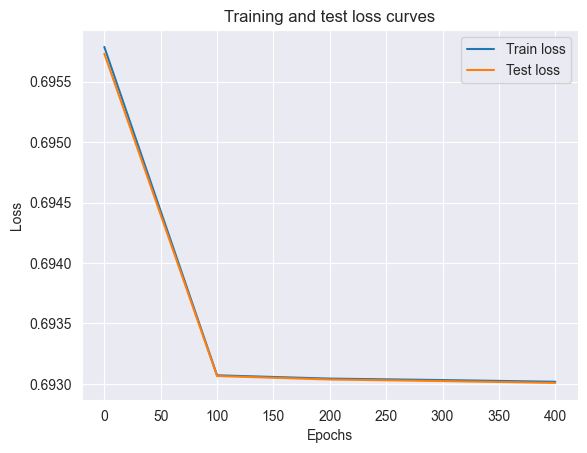

In [9]:
# Plot the loss curves
print("Large preprocessed dataset, scaled")
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [10]:
# train_loss_values, test_loss_values, epoch_count

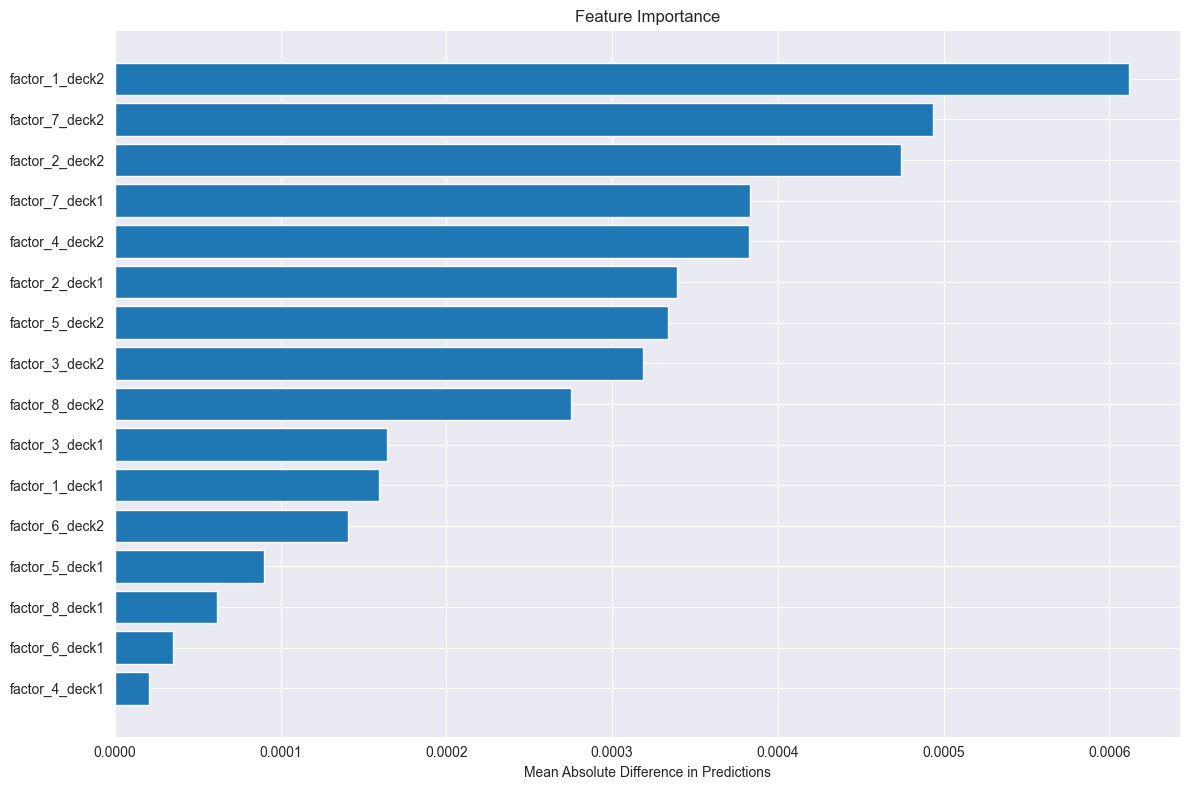

In [11]:
# Simpler feature importance method that works well with neural networks
def compute_feature_importance_simple(model, X, n_repeats=5):
    """Calculate feature importance by measuring impact of shuffling each feature"""
    importance = np.zeros(X.shape[1])
    model.eval()

    # Get baseline prediction
    X_tensor = torch.tensor(X).float()
    with torch.no_grad():
        baseline_preds = model(X_tensor).flatten().numpy()

    # For each feature
    for i in range(X.shape[1]):
        feature_importance = 0

        # Repeat the process multiple times
        for _ in range(n_repeats):
            # Create a copy of X with the feature shuffled
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])

            # Get predictions with shuffled feature
            X_permuted_tensor = torch.tensor(X_permuted).float()
            with torch.no_grad():
                permuted_preds = model(X_permuted_tensor).flatten().numpy()

            # Calculate importance as the decrease in performance
            feature_importance += np.mean(np.abs(baseline_preds - permuted_preds))

        importance[i] = feature_importance / n_repeats

    return importance

# Calculate feature importance
importance = compute_feature_importance_simple(model, X_test_np)

# Get feature names from dataframe
feature_names = df.columns[:-1]  # Exclude the target column

# Plot feature importance
plt.figure(figsize=(12, 8))
importance_sorted_idx = np.argsort(importance)
plt.barh(range(len(importance)), importance[importance_sorted_idx])
plt.yticks(range(len(importance)), [feature_names[i] for i in importance_sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Mean Absolute Difference in Predictions')
plt.tight_layout()
plt.show()

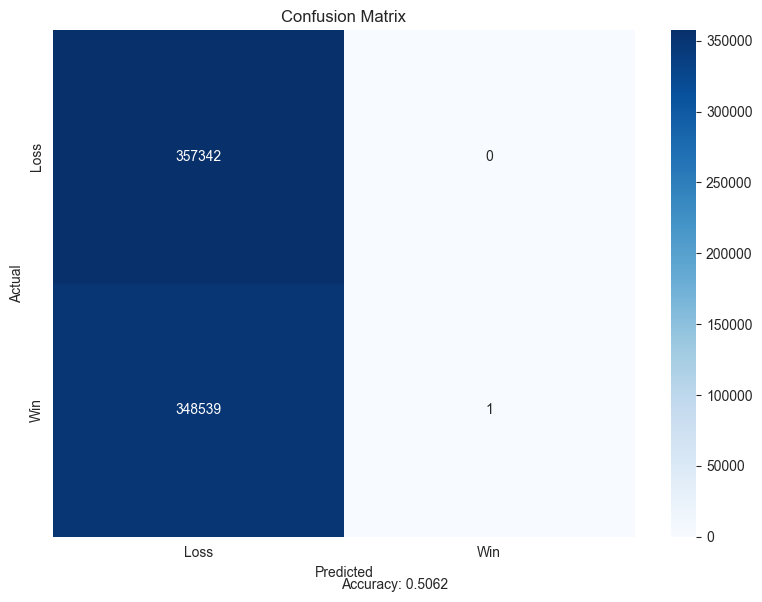

In [12]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(model, X_test, Y_test, threshold=0.5):
    # Get predictions from the model
    model.eval()
    with torch.no_grad():
        Y_test_pred = model(X_test).flatten()
        # Convert probabilities to binary predictions using threshold
        predicted_classes = (Y_test_pred >= threshold).float()

    # Convert tensors to numpy for sklearn
    y_true = Y_test.numpy()
    y_pred = predicted_classes.numpy()

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix with seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Win'],
                yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Calculate and display accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

# Call the function with your model
plot_confusion_matrix(model, X_test, Y_test)